Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 03: Analysis of behavioural data

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 7, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this exercise sheet we will start to work on a real dataset from an ongoing experiment. In this experiment the participants were asked to freely explore an unknown virtual city, called Seahaven, with an interactive map. After a sufficiently long exploration the participants were tested on three different tasks: 

- the **absolute orientation** of a single house towards the north cardinal direction
- the **relative orientation** between two houses 
- **pointing** from the location of one house to the other

Each task type was performed in two time conditions:

- **3 seconds** for spontaneous decisions
- **infinite** response time for cognitive reasoning

These measurements were repeated up to three times on different days.

We will provide you with more detailed information about this experiment in the tutorial. If you are interested in more than this feel free to have a look at the paper https://www.biorxiv.org/content/10.1101/539080v1.

A small side remark to the dataset: The RTs for the absolute task are exactly the same for both time conditions. This is an error that cannot be corrected on a short notice. Please keep that in mind, when you evaluate your plots.

## Assignment 0: Peer review for sheet 02 [3 pts]

Open an issue in the repository of the groups you have to check. The title of the issue should be your group name (e.g. "Group1). Comment on what was good and what was bad, the aesthetics and ease of reading the plots, what you would have done differently and how many points you would give them for their solutions.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 11, 9 | 5, 1  | 8, 2  | 2, 7 | 10, 6 | 7, 11 | 6, 5  | 4, 3  | 3, 8  | 1, 4   | 9, 10  |

## Assignment 1: Preprocessing [3 pts]

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats

### a) Preprocessing the data [1 pt]

First of all you should preprocess the data. This is an important step to avoid running into any problems when you start to analyse the data. Since we provide the Seahaven dataset as an excel file make sure to run ```pip install xlrd``` in your activated acc environment beforehand. This allows you to directly read from excel files.

- Import the data of all three tasks (Absolute, Relative, Pointing) into one dataframe. Since we don't need the whole data, load only the columns "ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer" and "Measurement".
- Clean the dataframe of all NaNs, i.e. remove all rows where at least one element is missing. How many rows have been removed?
- Change the values of the column "Answer". Replace each value "wrong" with 0 and each value "correct" with 1.

In [2]:
import xlrd

#Path to file
FILEPATH = os.path.join(os.getcwd(), 'Seahaven_dataset.xlsx')

#Print out warning message if file is not in current directiory
if(not os.path.isfile(FILEPATH)):
    print("Seahaven_dataset.xlsx file not found in current directory")

#load excel file to workbook
wb = xlrd.open_workbook(FILEPATH)

#these are the columns we want to import to dataframe
columns = ["ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer", "Measurement"]

#dataframe from excel file, containing all three sheets (AbsoluteTask, RelativeTask, PointingTask)
#it is a dictionary of the three dataframes, we use the dictionary to handle the dataframes easily
dataframeDict = pd.read_excel(wb, sheet_name=wb.sheet_names() , usecols=columns )


In [3]:
#to be able to count how many lines have been removed, we need the original length of the sheets individually
#this will be saved in the list "removed"
removed = []
for key,value in dataframeDict.items():
    removed.append(len(dataframeDict[key]))

#Inform User about the number of lines removed
print("Lines removed after filtering out NaNs")

#iterating through the sheets
for i, (key, value) in enumerate(dataframeDict.items()):
    #removing lines containing >=0 "NaN" values
    dataframeDict[key].dropna(how='any', inplace=True)
    #replacing all "wrong" by 0 and all "correct" by 1 in column "Answer"
    dataframeDict[key].Answer.replace(to_replace=["wrong","correct"], value=[0,1], inplace=True)
    #now we can count and print how many lines have been removed
    print(wb.sheet_names()[i], ":", removed[i]-len(dataframeDict[key]))

dataframeDict["AbsoluteTask"].head()

Lines removed after filtering out NaNs
AbsoluteTask : 522
RelativeTask : 370
PointingTask : 409


,ReactionTime,AngularDiffBin,Subject,Task,Time,Answer,Measurement
0,1.664824,150,1216,Absolute,3sec,0,1
1,0.865788,30,1216,Absolute,3sec,1,1
2,1.284187,60,1216,Absolute,3sec,0,1
3,2.081390,180,1216,Absolute,3sec,0,1
4,1.424746,120,1216,Absolute,3sec,1,1


#### b) Checking the distribution of the data [2 pts]

Most of the analysis techniques require normally distributed data. To get an idea on how the data looks like use the **preprocessed data** from 1.a) and plot for each task a violinplot that displays the data distribution of the RTs (note that you also have to distinguish between the two time conditions - 3sec and Infinite).

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the mean RT per subject.
- Make a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- Hint: Play with the keyword inner.
- Using your plots, what can you say about the distribution of the data? It is normally distributed? How is it skewed?

In [4]:
#to create the plots we will first save the calculated means to a new dataframe with 7 columns:
#the 0th column is the SubjectID, 
#columns 1&2 refer to the AbsoluteTask, 3&4 to the RelativeTask and the last two columns to the PointingTask
#for every task there are two columns, one for each trial type
plotColumns = ['SubID','3secA', 'infA', '3secR', 'infR', '3secP', 'infP']
#creating the new dataframe 
plotDF = pd.DataFrame(columns=plotColumns)

#a helper list to be able to add new lines to the dataframe
row =[]

#there are two types of trials
trialTypes =['3sec', 'Infinite']

#all three tasks were executed by the same amount of subjects (previously checked) thus we only need 
#to drop the duplicates of the column "Subject" of one of the three tasks to get a list of SubIDs
subIDs = dataframeDict['AbsoluteTask'].Subject.drop_duplicates()

#iterating through the 97 subjects to calculate the means individually
for ID in subIDs:
    #the first column always is the subject ID so we add the ID to the helper row
    row.append(ID)
    #from column 1 on the task changes every second column, thus we also need to iterate through the tasks/sheets
    #that are saved in our dataframe dictionary
    
    for key,value in dataframeDict.items():
        #grouping the current task/sheet by subject and task condition (which can be found in the column "time")
        grouped =  dataframeDict[key].groupby(['Subject','Time'])
        #for the current task and subject we have two different trials so we need a third loop that iterates through them
        
        for trialType in trialTypes:
            #this will calculate the mean of the current task, subject and trialtype
            mean = grouped.get_group((ID, trialType)).ReactionTime.mean()
            #appending to the helper row, the order will be correct by default due to the structure of the loops
            row.append(mean)
            
    #finally adding the new row to the dataset
    plotDF = plotDF.append(pd.Series(row, index=plotColumns), ignore_index = True)
    #clearing row for the next iteration
    row.clear()

plotDF.head()

,SubID,3secA,infA,3secR,infR,3secP,infP
0,1216.0,1.341370,1.341370,1.015738,2.554127,1.324583,1.663641
1,1217.0,1.810178,1.810178,1.673906,4.713493,1.877376,24.158690
2,1385.0,2.125904,2.125904,2.151579,1.840848,1.914552,2.654322
3,1531.0,1.610233,1.610233,0.856836,1.658017,0.551595,1.208625
4,1533.0,2.197194,2.197194,2.265275,5.037918,1.900894,5.202868


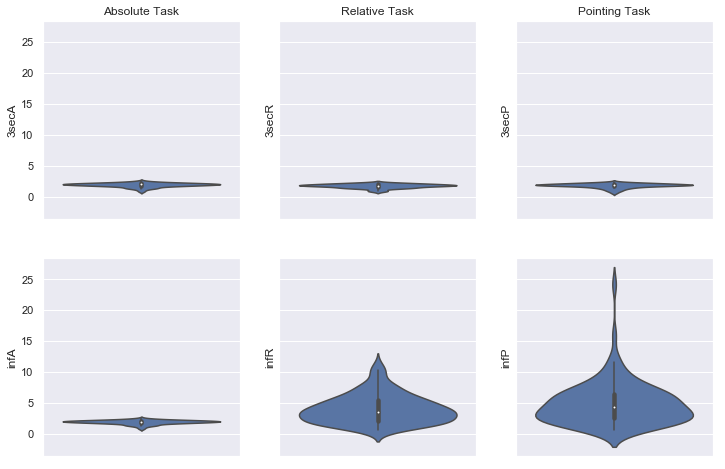

In [19]:
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(12,8), sharey=True, sharex="all")
axes = axes.flatten()

axes[0].set_title("Absolute Task")
axes[1].set_title("Relative Task")
axes[2].set_title("Pointing Task")

sns.violinplot(x=None, y=plotDF['3secA'], ax=axes[0])
sns.violinplot(x=None, y=plotDF['infA'], ax=axes[3])
sns.violinplot(x=None, y=plotDF['3secR'], ax=axes[1])
sns.violinplot(x=None, y=plotDF['infR'], ax=axes[4])
sns.violinplot(x=None, y=plotDF['3secP'], ax=axes[2])
sns.violinplot(x=None, y=plotDF['infP'], ax=axes[5])

You may have noticed that there are (extreme) outliers, that have to be removed from the **preprocessed data**.

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) look at the RTs and keep only the ones that are within +2 and -2 standard deviation:

$ |(RT_{group1} - mean(RT_{group1}))| \leq (2*std(RT_{group1})) $

$group1$ = e.g. data of absolute task for time condition 3sec

- Make again a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- How does the distribution of the data look now? Is it still skewed?

In [6]:
# this list will have 6 entries, for each task and then for each time condition one entry 
# in the end it will be used for the plots and the original dataframe has not to be changed
dataframeList = []

# take the preprocessed data and go through all the three tasks 
for task in dataframeDict:
    # group the dataframe by the timecondition
    grouped = dataframeDict[task].groupby(['Time'])
    
    # for each time condition calculate the mean 
    for timeCond in trialTypes:
        # this will calculate the mean of the current task and the trialtype (3sec or infinite)
        mean = grouped.get_group(timeCond).ReactionTime.mean()
        std = grouped.get_group(timeCond).ReactionTime.std()               
        # check if the RT in each row is not an extreme outlier
        # calculate the z-value and check if the value is more than 2 stds away form the mean
        # if this is the case the the complete row has to be dropped
        # it yields z = (RT-mean)/std
        dropByIndex = grouped.get_group(timeCond).index[((grouped.get_group(timeCond).ReactionTime - mean)/std) > 2]
        dataframeList.append(grouped.get_group(timeCond).drop(dropByIndex))

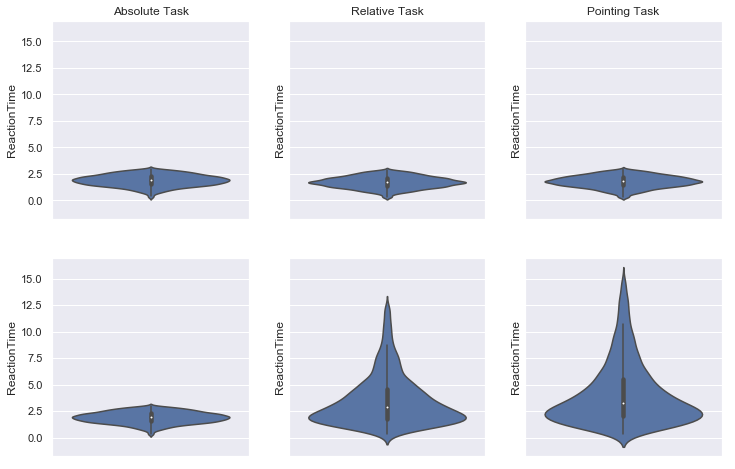

In [7]:
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(12,8), sharey=True, sharex="all")
axes = axes.flatten()

axes[0].set_title("Absolute Task")
axes[1].set_title("Relative Task")
axes[2].set_title("Pointing Task")


# In the list of dataframes we have the data in the following order:
# AbsoluteTask 3sec, AbsoluteTask Infinite, RelativeTask 3sec, RelativeTask Infinite, 
# PointingTask 3sec, PointingTask Infinite 
# thus we can plot each group in a different subplot

sns.violinplot(x=None, y=dataframeList[0]['ReactionTime'], ax=axes[0])
sns.violinplot(x=None, y=dataframeList[1]['ReactionTime'], ax=axes[3])
sns.violinplot(x=None, y=dataframeList[2]['ReactionTime'], ax=axes[1])
sns.violinplot(x=None, y=dataframeList[3]['ReactionTime'], ax=axes[4])
sns.violinplot(x=None, y=dataframeList[4]['ReactionTime'], ax=axes[2])
sns.violinplot(x=None, y=dataframeList[5]['ReactionTime'], ax=axes[5])

**Please make sure that you use the preprocessed data without outliers for the following assignments!**

## Assignment 2: Checking for possible hypotheses [5 pts]

### a) Hypothesis 1 [2 pt]

**Hypothesis 1:** "Given that subjects are limited by time, if they are faster in RT they are also less accurate."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a scatterplot of the mean RT (x-axis) and the accuracy (y-axis) for the time condition "3sec". 
- Make a second scatterplot and add a simple linear regression line to it. Calculate the slope of the regression line (you are allowed to use scipy). 
- Considering your results, what can you say about the hypothesis?

In [23]:
plotDF.head()
# at index 3, 7 and 11 we have to add a new column because we have for each three tasks 
# helper list, indicates start of new pair of columns 
columns = [3,7,11]

#inserting missing columns to the existing dataframe
plotDF.insert(value=np.nan, loc = 3, column='3secAccuracyA')
plotDF.insert(value=np.nan, loc = 4, column='infAccuracyA')
plotDF.insert(value=np.nan, loc = 7, column='3secAccuracyR')
plotDF.insert(value=np.nan, loc = 8, column='infAccuracyR')
plotDF.insert(value=np.nan, loc = 11, column='3secAccuracyP')
plotDF.insert(value=np.nan, loc = 12, column='infAccuracyP')

In [24]:
#groups for each sheet/Task type
grouped1 =  dataframeDict['AbsoluteTask'].groupby(['Subject', 'Time'])
grouped2 =  dataframeDict['RelativeTask'].groupby(['Subject', 'Time'])
grouped3 =  dataframeDict['PointingTask'].groupby(['Subject', 'Time'])

#helper list for iterating through groups
groups = [grouped1, grouped2, grouped3]
#helper row to be able to iterate through subjects
row = 0

#for each subject we need new mean values
for ID in subIDs:
    #iterating through different groups
    for i,group in enumerate(groups):
        #Accuracy mean for 3sec task with the respective ID and group
        mean3sec = group.get_group((ID, '3sec')).Answer.mean()
        #Accuracy mean for Infinite task with the respective ID and group
        meanInf = group.get_group((ID, 'Infinite')).Answer.mean()
        #saving the mean value to the current row and column (which can be taken from the helper list)
        plotDF.iloc[row, columns[i]] = mean3sec
        #mean Infinite value needs to be saved to the column right next to the last one
        plotDF.iloc[row, (columns[i]+1)] = meanInf
    #with each new subID we need to switch to the next row
    row = row+1
plotDF.head()


,SubID,3secA,infA,3secAccuracyA,infAccuracyA,3secR,infR,3secAccuracyR,infAccuracyR,3secP,infP,3secAccuracyP,infAccuracyP
0,1216.0,1.341370,1.341370,0.485714,0.485714,1.015738,2.554127,0.333333,0.555556,1.324583,1.663641,0.361111,0.583333
1,1217.0,1.810178,1.810178,0.742857,0.742857,1.673906,4.713493,0.529412,0.555556,1.877376,24.158690,0.571429,0.555556
2,1385.0,2.125904,2.125904,0.545455,0.545455,2.151579,1.840848,0.411765,0.472222,1.914552,2.654322,0.500000,0.583333
3,1531.0,1.610233,1.610233,0.647059,0.647059,0.856836,1.658017,0.527778,0.416667,0.551595,1.208625,0.617647,0.611111
4,1533.0,2.197194,2.197194,0.545455,0.545455,2.265275,5.037918,0.515152,0.666667,1.900894,5.202868,0.485714,0.611111


### b) Hypothesis 2 [1 pt]

**Hypothesis 2:** "Given that subjects have infinite time, they perform better."

- Use the data of all three tasks.
- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the tasks (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

In [9]:
# TODO

### d) Hypothesis 3 [1 pt]

**Hypothesis 3:** "With each subsequent session subjects get better in performance."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the measurement (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Make also a pointplot of the measurement (x-axis) and RT (y-axis) for both time conditions (3sec / Infinite).  Make sure that the data is displayed clearly. You may split up the single plots for a better overview.
- Considering your plots, what can you say about the hypothesis?

In [22]:
# we use the data from task 2a) so we don't have to loop through the dataset every task

# we plot the measurement on the x-axis and the accuracy on the y-axis
# we need the measurement data for all subIDs so we need to first group by subID and get the measurements
grouped = dataframeDict["RelativeTask"].groupby(['Subject'])

print(grouped.head())


      ReactionTime  AngularDiffBin  Subject      Task  Time  Answer  \
0         0.823629           120.0   1216.0  Relative  3sec       0   
1         1.999603           150.0   1216.0  Relative  3sec       0   
2         0.566518            60.0   1216.0  Relative  3sec       0   
3         1.067995            90.0   1216.0  Relative  3sec       0   
4         0.606073           180.0   1216.0  Relative  3sec       0   
72        2.163446           120.0   1217.0  Relative  3sec       1   
74        1.823343            60.0   1217.0  Relative  3sec       1   
75        0.931664            90.0   1217.0  Relative  3sec       1   
76        1.519006           180.0   1217.0  Relative  3sec       0   
78        1.887034            90.0   1217.0  Relative  3sec       1   
144       2.175113           120.0   1385.0  Relative  3sec       0   
145       2.107829           150.0   1385.0  Relative  3sec       1   
146       2.775731            60.0   1385.0  Relative  3sec       1   
147   

### c) Hypothesis 4 [1 pts]

**Hypothesis 4:** "When the angular difference between houses increases subjects are more accurate in the relative task."

- Use the data of the relative task.
- For each angular difference (see "AngularDiffBin") calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the angular differences (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance. Make sure that the angular differences are displayed in ascending order.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

In [11]:
# TODO

## Assignment 3: T-test [2 pts]

We will perform a two-sample t-test, i.e. we compare the mean of two groups under the assumption that both are independent and normally distributed with unknown but equal variances. In this case we will look at the data of the relative task and compare the accuracies of the two time conditions (3sec / Infinte). We will ignore that there are different measurement days!

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Check if the data is normally distributed using scipy.stats.normaltest.


- Compute the t-statistics: $ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $

$\bar{x}_1$: mean accuracy of all subjects for time condition "3sec" <br>
$\bar{x}_2$: mean accuracy of all subjects for time condition "Infinite" <br>
$n_1$: sample size for time condition "3sec" <br>
$n_2$: sample size for time condition "Infinite"


- with $ s^2 = \frac{\sum_{i=1}^n{(x_i - \bar{x})^2}}{n-1} $

$x_i$: accuracy of subject i <br>
$\bar{x}$: mean accuracy of all subjects <br>
$n$: sample size


- Calculate the degrees of freedom: $ df = n_1 + n_2 -2 $
- What does the p-value of a t-test tell you in general? Also explain what your calculated p-value tells you specifically (given $\alpha = 0.05$)?

In [12]:
# TODO

# gives you the p-value after comparing the t-statistic with the critical t value (computed internally) 
p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))

# test if your calculation is correct
t2, p2 = stats.ttest_ind(x1,x2)
print("t = " + str(t2))
print("p = " + str(p2))

NameError: name 't' is not defined